In [1]:
# import libraries
import pandas as pd
import operator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

#3.1.1 Prepare the Data

In [2]:
# read in the dataset locally
chip_dataset = pd.read_csv('/content/chip_dataset.csv')

# drop the first column which list all the indices
chip_dataset.drop('Unnamed: 0', inplace=True, axis=1)

chip_dataset

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD,NaN,NaN,NaN
1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD,NaN,NaN,NaN
2,Intel Core i5-1145G7,CPU,2020-09-02,10.0,28.0,NaN,NaN,2600.0,Intel,Intel,NaN,NaN,NaN
3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.0,80.0,160.0,1400.0,1800.0,Intel,Intel,NaN,NaN,NaN
4,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.0,125.0,258.0,758.0,3700.0,Unknown,AMD,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4849,NVIDIA Quadro 3000M,GPU,2011-02-22,40.0,75.0,332.0,1950.0,450.0,TSMC,NVIDIA,NaN,432.0,36.0
4850,Intel GMA 950,GPU,2005-06-01,90.0,7.0,NaN,NaN,250.0,Intel,Intel,NaN,NaN,NaN
4851,NVIDIA GeForce GT 320M,GPU,2010-03-03,40.0,23.0,100.0,486.0,500.0,TSMC,NVIDIA,NaN,52.8,NaN
4852,NVIDIA GeForce FX 5200,GPU,2003-03-06,150.0,NaN,65.0,29.0,250.0,TSMC,NVIDIA,NaN,NaN,NaN


In [3]:
# transform categorical feature 'Release Date' to numerical value
for i in range(len(chip_dataset['Release Date'])):
  if 'Na' in chip_dataset.iat[i, 2] :
    chip_dataset.iat[i, 2] = np.NaN
  else:
    year = int(chip_dataset.iat[i, 2][0:4])-2000
    month = int(chip_dataset.iat[i, 2][5:7])/12
    day = int(chip_dataset.iat[i, 2][8:10])/365
    chip_dataset.iat[i, 2] = year+ month + day

In [4]:
# split the data to CPU and GPU subsets
grouped = chip_dataset.groupby(chip_dataset['Type'])

# spilt and get the CPU dataset
CPU = grouped.get_group('CPU')
del CPU['FP16 GFLOPS']
del CPU['FP32 GFLOPS']
del CPU['FP64 GFLOPS']

# split and get the GPU dataset
GPU = grouped.get_group('GPU')

In [5]:
# data normalization for CPU dataset
from sklearn.preprocessing import MinMaxScaler
CPU_normal = CPU.copy().drop(columns=['Product','Type','Foundry','Vendor'])
scaler = MinMaxScaler()
scaler.fit(CPU_normal)
fit = scaler.fit_transform(CPU_normal)
# fit = pd.DataFrame(fit, columns = CPU_normal.columns)
final = pd.DataFrame(data = fit, columns = CPU_normal.columns, index = CPU_normal.index)
CPU_normal = CPU.copy().drop(columns=CPU_normal.columns).join(final)
CPU_normal

,Product,Type,Foundry,Vendor,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz)
0,AMD Athlon 64 3500+,CPU,Unknown,AMD,0.321634,0.335260,0.110276,0.111274,0.004436,0.390244
1,AMD Athlon 200GE,CPU,Unknown,AMD,0.875211,0.040462,0.085213,0.279649,0.248552,0.634146
2,Intel Core i5-1145G7,CPU,Intel,Intel,0.970584,0.017341,0.067669,NaN,NaN,0.487805
3,Intel Xeon E5-2603 v2,CPU,Intel,Intel,0.634806,0.086705,0.197995,0.232796,0.071127,0.292683
4,AMD Phenom II X4 980 BE,CPU,Unknown,AMD,0.523187,0.219653,0.310777,0.376281,0.037625,0.756098
...,...,...,...,...,...,...,...,...,...,...
2187,Intel Xeon Gold 6312U,CPU,Intel,Intel,0.999080,0.017341,0.461153,NaN,NaN,0.439024
2188,AMD Ryzen 9 4900H,CPU,TSMC,AMD,0.948449,0.000000,0.132832,0.226940,0.509471,0.658537
2189,Intel Core 2 Duo E6550,CPU,Intel,Intel,0.339117,0.335260,0.160401,0.207906,0.013255,0.422683
2190,AMD Opteron 246,CPU,Unknown,AMD,0.215248,0.479769,0.210526,NaN,0.003601,0.341463


In [6]:
#data normalization for GPU dataset
from sklearn.preprocessing import MinMaxScaler
GPU_normal = GPU.copy().drop(columns=['Product','Type','Foundry','Vendor'])
scaler = MinMaxScaler()
scaler.fit(GPU_normal)
fit = scaler.fit_transform(GPU_normal)

#add back to the dataframe
final = pd.DataFrame(data = fit, columns = GPU_normal.columns, index = GPU_normal.index)
#GPU_normal = GPU.copy().drop(columns=GPU_normal.columns).join(final)
GPU_normal

,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
2192,11.341553,32.0,95.0,216.0,1160.0,100.0,NaN,NaN,NaN
2193,2.568493,150.0,NaN,174.0,80.0,200.0,NaN,NaN,NaN
2194,19.22968,14.0,25.0,132.0,3300.0,1469.0,18.38,1177.0,36.77
2195,8.255479,130.0,NaN,NaN,NaN,200.0,NaN,12.8,NaN
2196,8.832192,55.0,20.0,73.0,242.0,600.0,NaN,96.0,NaN
...,...,...,...,...,...,...,...,...,...
4849,11.226941,40.0,75.0,332.0,1950.0,450.0,NaN,432.0,36.00
4850,5.50274,90.0,7.0,NaN,NaN,250.0,NaN,NaN,NaN
4851,10.258219,40.0,23.0,100.0,486.0,500.0,NaN,52.8,NaN
4852,3.266438,150.0,NaN,65.0,29.0,250.0,NaN,NaN,NaN


In [7]:
# encode the categorical features
CPU['Vendor'] = CPU['Vendor'].replace(['AMD', 'Intel'], ['0', '1'])
GPU['Vendor'] = GPU['Vendor'].replace(['AMD', 'Intel', 'Other', 'NVIDIA', 'ATI'], ['0', '1','2','3','4'])

<ipython-input-7-ab1b57c62c2f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPU['Vendor'] = CPU['Vendor'].replace(['AMD', 'Intel'], ['0', '1'])
<ipython-input-7-ab1b57c62c2f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GPU['Vendor'] = GPU['Vendor'].replace(['AMD', 'Intel', 'Other', 'NVIDIA', 'ATI'], ['0', '1','2','3','4'])


In [8]:
# drop NaN rows

#Here we will use y= number of transistors and x to be other variable
CPU_normal = CPU_normal.dropna()
#CPU.drop('Transistor')
X = CPU_normal. iloc[:, [4,5,6,7,9]]
y = CPU_normal. iloc[:, [8]]

X.head()

,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Freq (MHz)
0,0.321634,0.335260,0.110276,0.111274,0.390244
1,0.875211,0.040462,0.085213,0.279649,0.634146
3,0.634806,0.086705,0.197995,0.232796,0.292683
4,0.523187,0.219653,0.310777,0.376281,0.756098
5,0.634806,0.086705,0.235589,0.232796,0.439024


#3.1.2 Linear and Polynomial Regression (using Release Date to predict Transistor)
We will first start with linear regression to see if we could recover any type of relationship between the variables and transistors.

Because the Moore's law stated that the number of transistors in a dense integrated circuit (IC) doubles about every two years, we will first focus on building an linear regression model to explain how could that be interpet on our dataset.

In [10]:
#Here we will use y= number of transistors and x to be other variable
CPU_normal = CPU_normal.dropna()
#CPU.drop('Transistor')
X = CPU_normal. iloc[:, [4,5,6,7,9]]
y = CPU_normal. iloc[:, [8]]

X

,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Freq (MHz)
0,0.321634,0.335260,0.110276,0.111274,0.390244
1,0.875211,0.040462,0.085213,0.279649,0.634146
3,0.634806,0.086705,0.197995,0.232796,0.292683
4,0.523187,0.219653,0.310777,0.376281,0.756098
5,0.634806,0.086705,0.235589,0.232796,0.439024
...,...,...,...,...,...
2180,0.919296,0.000000,0.385965,0.106881,0.609756
2182,0.027445,0.710983,0.167920,0.146413,0.321220
2188,0.948449,0.000000,0.132832,0.226940,0.658537
2189,0.339117,0.335260,0.160401,0.207906,0.422683


In [9]:
CPU_normal

,Product,Type,Foundry,Vendor,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz)
0,AMD Athlon 64 3500+,CPU,Unknown,AMD,0.321634,0.335260,0.110276,0.111274,0.004436,0.390244
1,AMD Athlon 200GE,CPU,Unknown,AMD,0.875211,0.040462,0.085213,0.279649,0.248552,0.634146
3,Intel Xeon E5-2603 v2,CPU,Intel,Intel,0.634806,0.086705,0.197995,0.232796,0.071127,0.292683
4,AMD Phenom II X4 980 BE,CPU,Unknown,AMD,0.523187,0.219653,0.310777,0.376281,0.037625,0.756098
5,Intel Xeon E5-2470 v2,CPU,Intel,Intel,0.634806,0.086705,0.235589,0.232796,0.071127,0.439024
...,...,...,...,...,...,...,...,...,...,...
2180,AMD EPYC 7262,CPU,TSMC,AMD,0.919296,0.000000,0.385965,0.106881,0.196368,0.609756
2182,AMD Athlon XP 2600+ DTR,CPU,Unknown,AMD,0.027445,0.710983,0.167920,0.146413,0.001357,0.321220
2188,AMD Ryzen 9 4900H,CPU,TSMC,AMD,0.948449,0.000000,0.132832,0.226940,0.509471,0.658537
2189,Intel Core 2 Duo E6550,CPU,Intel,Intel,0.339117,0.335260,0.160401,0.207906,0.013255,0.422683


In [37]:
from sklearn.model_selection import train_test_split

y = CPU_normal['Transistors (million)']
X = CPU_normal['Release Date']

X = X.to_numpy()
y = y.to_numpy()
X = [ele for index,ele in enumerate(X) if y[index] != 0]
y = [ele for ele in y if ele != 0]
X = np.array(X)
y = np.array(y)

log_y = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, log_y, test_size=0.2, random_state=42)

In [38]:
X_train = X_train.reshape(-1, 1)
X_train.shape, y_train.shape

((1195, 1), (1195,))

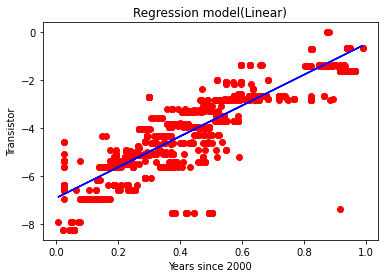

array([6.44605229])

In [39]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

plt.scatter(X_train, y_train, color='red')
plt.plot(X_train, lin_reg.predict(X_train),color='blue')
plt.title("Regression model(Linear)")
plt.xlabel('Years since 2000')
plt.ylabel('Transistor')
plt.show()

lin_reg_yhat_train = lin_reg.predict(X_train)
lin_reg_yhat_test = lin_reg.predict(X_test.reshape(-1, 1))

coefficients = lin_reg.coef_
coefficients

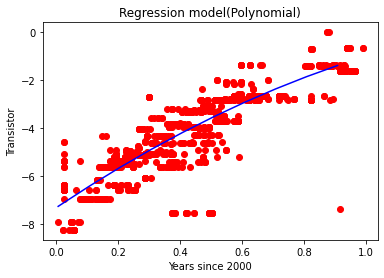

array([ 0.        ,  8.66905965, -2.33533443])

In [40]:
# polynomial regression of degree 2
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X_train)

poly_reg2 = LinearRegression()
poly_reg2.fit(X_poly, y_train)
 
X_grid = np.arange(min(X_train),max(X_train),0.1)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(X_train, y_train, color='red') 
 
plt.plot(X_grid, poly_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 
 
plt.title("Regression model(Polynomial)")
plt.xlabel('Years since 2000')
plt.ylabel('Transistor')
plt.show()

coefficients = poly_reg2.coef_
coefficients

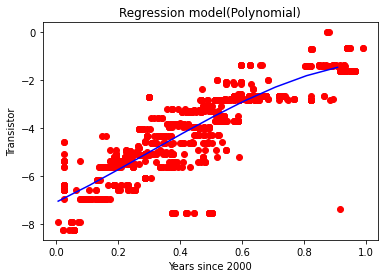

array([ 0.        ,  6.18118661,  3.84650245, -4.20674681])

In [41]:
# polynomial regression of degree 3
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)

poly_reg3 = LinearRegression()
poly_reg3.fit(X_poly, y_train)
 
X_grid = np.arange(min(X_train),max(X_train),0.1)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(X_train, y_train, color='red') 
 
plt.plot(X_grid, poly_reg3.predict(poly_reg.fit_transform(X_grid)),color='blue') 
 
plt.title("Regression model(Polynomial)")
plt.xlabel('Years since 2000')
plt.ylabel('Transistor')
plt.show()

coefficients = poly_reg3.coef_
coefficients

We stop at polynomial of degree 3 for predicting transistor number using release date (i.e. years since 2000). Since there is no noticable changes on the curve on the graph which we observe above. 

We will calcuate the SSE/SSR which is the percentage of variation that coud be explain by the linear regression model

From the model we found the time and Transistor is obviously not in a linear relation. The Moore's law predict there are log() relationship between these two variable. So we are trying to transform the data in to x'=log(x) and re-construct the linear regression model

In [42]:
rmse = np.sqrt(mean_squared_error(y_train, lin_reg_yhat_train))
r2 = r2_score(y_train, lin_reg_yhat_train)
print('Training RMSE: %8.15f' % rmse)
print('Training R2: %8.15f' % r2)

Training RMSE: 0.866631524681666
Training R2: 0.741804860177362


In [43]:
rmse = np.sqrt(mean_squared_error(y_test, lin_reg_yhat_test))
r2 = r2_score(y_test, lin_reg_yhat_test)
print('Testing RMSE: %8.15f' % rmse)
print('Testing R2: %8.15f' % r2)

Testing RMSE: 0.915392403943106
Testing R2: 0.727656462368859


Using knowledge from statistic, We know the R2 value is the proportion of the variation in the dependent variable that is predictable from the independent variables. Here, both the R2 and the adjusted R2 value are very high, which means that almost all the variation in Transistors can be explained by the independent variables on the Release Date.